obs if you are running this in vscode, you need to select python environment as prolif, and then select the prolif environment as your kernel too 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import analysis_functions
import seaborn as sns
from typing import Optional
import simulation_names as sims

In [2]:
color_l= ["#539C44", "#37456d", "#E27439", "grey"]

# Load unis using analysis scripts

In [5]:
all_unis, all_lens = analysis_functions.load_unis(sim_list=[
                                                            sims.PfHT_MMV12,
                                                            sims.PfHT_MMV8, 
                                                            sims.W412A_MMV12, 
                                                            sims.GLUT1_MMV12
                                                            ]
                                                )

# Run fp , save df, put in dict

If you don't change anything here you could turn this calculation to false to save time. Right now I have skip50 on to make the calculation smoother

In [7]:
all_fp_dfs = {}
skip = 1

for condition in all_unis.keys():
    # print(condition)
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[condition]):
        if (
            condition != "PfHT_apo"
        ):  ## no need to run fingerprints on sim that doesn't have mmv...
            df = analysis_functions.get_fp_dataframe(
                u=rep_fp,
                skip=skip,
                run_calc=False,
                filename=f"{condition}.replica_{n+1}.skip{skip}",
            )
            temp_fp_dfs.append(df)
    all_fp_dfs[condition] = temp_fp_dfs

# Calculate percentage of whatever interaction you want

This was originally for pi stacking with w412 but you could do this with anything

Just find where TRP412 (or equivalent) is in the dataframe, then divide sum (since only True or False) by total sim length


First function `percentage_specific_intxn_all_sims` will output an array with shape (`[n_conditions], [n_replicas]`)

Second function `plot_grouped_barplot` will plot a grouped barplot of the array

In [5]:
def percentage_specific_intxn_all_sims(
        PfHT_residue_number: str,
        GLUT1_residue_number: str,
        interaction_name: str,
        all_fp_dfs: dict = all_fp_dfs,
        n_conditions: int = 4,
        n_reps: int = 3
) -> np.array: 
    """
    Will read the dict of fingerprints, condition by condition, for each replica
    Find percentage of True in each df
    Will return a np array with shape (n_conditions, n_reps) (4,3) currently

    """   
    
    all_percentages = np.zeros((n_conditions, n_reps))

    for cond_index, condition in enumerate(all_fp_dfs.keys()):
        for rep_index, replica in enumerate(all_fp_dfs[condition]):
            if "GLUT1" in condition:
                try:
                    percent_True = (replica[GLUT1_residue_number][interaction_name].sum()) / len(replica)
                except KeyError:  # if there is never pi stacking, won't find it in the df
                    percent_True = 0

            else:
                try:
                    percent_True = (replica[PfHT_residue_number][interaction_name].sum()) / len(replica)
                except KeyError:  # if there is never pi stacking, won't find it in the df
                    percent_True = 0


            all_percentages[cond_index, rep_index] = percent_True
    
    return all_percentages

In [6]:
def plot_grouped_barplot(
        percentage_array: np.array,
        ax: plt.axes,
        intxn_name: str,
        all_fp_dfs: dict = all_fp_dfs
) -> plt.axes:

    x = np.arange(np.shape(percentage_array)[0])
    width = 0.2
    ax.bar(x - 0.2, percentage_array[:, 0], width, color=color_l)
    ax.bar(x, percentage_array[:, 1], width, color=color_l, alpha = 0.8)
    ax.bar(x + 0.2, percentage_array[:, 2], width, color=color_l, alpha = 0.6)

    ax.set_xticks(x, all_fp_dfs.keys())
    ax.set_xlabel("Condition")
    ax.set_ylabel(f"Percent {intxn_name} in sim")
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
    #ax.legend(["Rep 1", "Rep 2", "Rep 3"])

The `res_num_map` just helps to recall these functions for certain residues we are interested in

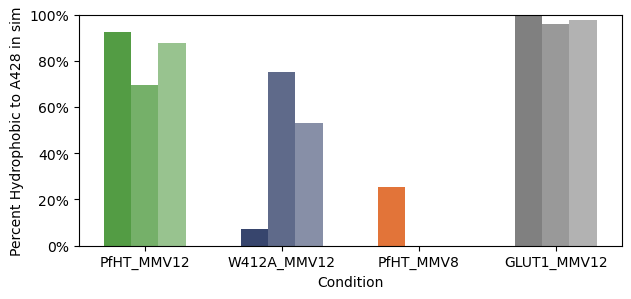

In [7]:
## actual #: [PfHT tpr #, GLUT1 tpr #, intxn name]
res_num_map = {
    'W412':['TRP391', 'TRP381', 'PiStacking'], 
    'S432':['SER411', 'GLY401', 'HBAcceptor'],
    'Q169':['GLN148', 'GLN154', 'HBAcceptor'],
    'D425':['ASP404', 'PRO394', 'HBDonor'],
    'P149':['PRO128', 'PRO134', 'Hydrophobic'],
    'H168':['HSD147','HSD153', 'Hydrophobic'],
    'A428':['ALA407', 'ILE397', 'Hydrophobic']
            
            }

res = 'A428'

intxn = percentage_specific_intxn_all_sims(
    PfHT_residue_number=res_num_map[res][0],
    GLUT1_residue_number=res_num_map[res][1],
    interaction_name=res_num_map[res][2]
)

f,ax = plt.subplots(1,1, figsize=(7,3))
plot_grouped_barplot(
    percentage_array=intxn, 
                     ax=ax,
                     intxn_name=f'{res_num_map[res][2]} to {res}'
                     )


# Plotting all interaction types, all replicas on one bar

The function `get_all_mean_intxn_time_dfs_wide` will take a fingerprint dataframe and combine based on an interaction time, reporting back the % intxn time
- Currently the function assumes that you have 3 replicas, but this would be easy to change

---
The output of this is in a wide dataframe, so then we use `process_wide_df` to melt the array, and rename oolumns meaningfully

---
Lastly, plot the dataframe in an sns plot

In [10]:
# keep for now, will remove after I validate Ivens code

def get_all_mean_intxn_time_dfs_wide(
    intxn_name: str,
    mean_cutoff: float=0.1,    
    all_fp_dfs: dict=all_fp_dfs
) -> pd.DataFrame:
    """
    Calculates the mean interaction time for a specified interaction type
    Returns a multilevel dataframe with residue interacting as the index,
      and replica #(python indexed) as the column name, for each condition multi index
      this is in wide format, but we need to be able to keep Nans in place for ensuring that zeros
      are counted

      Intention is therefore to drop GLUT1 from this dataframe, and then melt along residues
      to get a long form dataframe
    """

    all_mean_interactions = {}
    for condition in all_fp_dfs.keys():
        mean_intxn_all_reps = []
        for rep in all_fp_dfs[condition]:
            intxn_group_over_time = rep.xs(intxn_name, level="interaction", axis=1)
            mean_intxn = intxn_group_over_time.mean()
            mean_intxn = mean_intxn.loc[mean_intxn>mean_cutoff]
            mean_intxn_all_reps.append(mean_intxn)
        mean_intxn_all_reps = pd.concat(mean_intxn_all_reps, axis=1, keys=[f'replica 1', 'replica 2', 'replica 3'])
        all_mean_interactions[condition] = mean_intxn_all_reps

    all_mean_interactions = pd.concat(all_mean_interactions, axis=1)

    return all_mean_interactions


In [11]:
def process_wide_df(
  df: pd.DataFrame,
  index_col_name: str,
  condition_to_remove: Optional[str] = None,
  index_name: str='index',
  top_level_melt_name: str='protein',
  lower_level_melt_name: str='replica',
  add_21: bool=False
) -> pd.DataFrame:
  """
  Wide multi index dataframe as input with the following format:
  eventual label as index (ie residue name)
  condition name as top label
  replica name as under label 
  This isn't strictly necessary but it is designed this way because
  other functions make dataframes like this
  ie: 
  index:              PfHT_MMV12     ... GLUT1_MMV12
          replica 1:   replica 2:         replica 3:
  GLN104     value1       value3            value500
  ASP205     value2       value4

  is a typical format for input
  and output will be like:
         value:     replica:   protein:    residue:
  0      value1     replica1    PfHT_MMV12   GLN104
  1      value3     replica2    PfHT_MMV12   GLN104
  ...
  20     value2     replica3   PfHT_MMV12   ASP205


  will melt array and rename the index to the variable 'index_col_name'
  (this might be residue, n_interactions...). If index is from prolif
  directly, it's probably named "protein"


  """
  ## sometimes there might be values specific only to the 
  ### condition you want to remove, so drop these from the dataframe
  if condition_to_remove is not None:
    del df[condition_to_remove]
    df = df.dropna(how='all', axis=0) 


  ## for the melting, if you have gathered replicas together, and then
  #### gathered conditions on top of that (as is often the structure of other 
  ##### functions of this script), the top_level_melt_name is usually 'protein'
  ###### and lower_level_melt_name is 'residue'
  df = (df.fillna(0.0)
  .reset_index()
  .rename({index_name:index_col_name}, axis=1)
  .melt(id_vars=[index_col_name], var_name=[top_level_melt_name, lower_level_melt_name])
  )

  ### finally, add 21 to res numbers
  ## TODO - conditional if PfHT
  if add_21:
    df['resnr']= df['residue'].str[3:].astype(int)+21
    df['residue']= df['residue'].str[:3]+df['resnr'].astype(str)
    del df['resnr']

  return df

Choose interaction name here with `intxn_name`
Most common for PfHT and MMV are:
1. `HBAcceptor`
2. `HBDonor`
3. `Hydrophobic`
4. `PiStacking`

In [12]:
intxn_name = 'HBAcceptor'
n_intxns = get_all_mean_intxn_time_dfs_wide(
    intxn_name=intxn_name
)

n_intxns= process_wide_df(
    df= n_intxns,
    index_col_name= 'residue',
    condition_to_remove= 'GLUT1_MMV12',
    index_name= 'protein',
    top_level_melt_name= 'protein', #put condition names together in col called protein
    lower_level_melt_name= 'replica',  # put replica columns together into one column called replica
    add_21= True
)

plot with sns. Use barplot and stripplot to show the mean of the 3 reps, and then the raw rep data on top

/tmp/ipykernel_696979/365372372.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.stripplot(data=all_mean_interactions,


(0.0, 1.1)

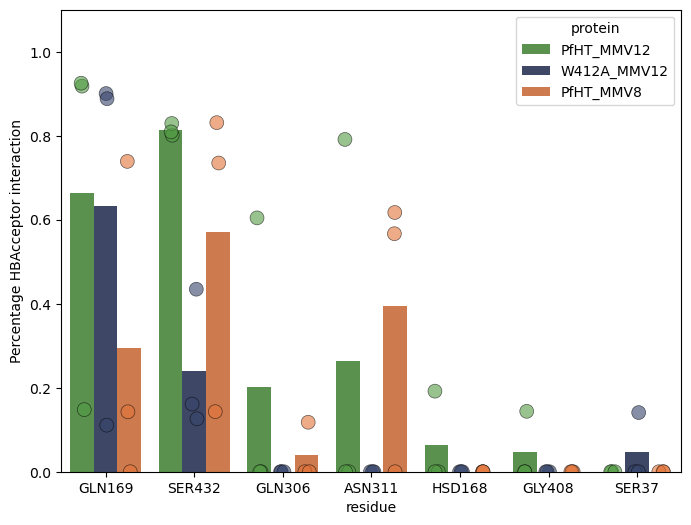

In [13]:
f,ax = plt.subplots(1,1, figsize=(8,6))
sns.barplot(data=n_intxns, 
            x='residue',
            y='value',
            hue= 'protein',
            errorbar= None,
            ax= ax,
            palette= color_l
            )

sns.stripplot(data=n_intxns, 
            x='residue',
            y='value',
            hue= 'protein',
            ax= ax,
            dodge=True,
            alpha= 0.6,
            edgecolor='black',
            linewidth=0.5,
            legend=False,
            size=10,
            palette= color_l
            )

ax.set_ylabel(f"Percentage {intxn_name} interaction")
ax.set_ylim(0,1.1)

# Total number of interactions (of a certain type) in a frame
To plot this raw is a mess, so again percentages are useful here

In [118]:
def pct_interactions_per_frame(
        intxn_name: str,
        all_fp_dfs: str= all_fp_dfs,
        percentage: bool=True,
        value_counts: bool=True
) -> pd.DataFrame:
    """ 
    In all dataframes, find the sum across columns for a specific interaction type
    this will give you the n interactions per frame (since boolean df)

    Then, count the occurence of each value, 
    If 'percentage' is set to true, then divide this occurence by the total length of the df to get the %

    This will return a dataframe in a wide format, which we can then postprocess later
    """
    temp_all = {}
    for name, fp_df_l in all_fp_dfs.items():
        temp_rep = []
        for rep_n, rep_df in enumerate(fp_df_l):
            n_counts = (rep_df.xs(intxn_name, level='interaction', axis=1)
                        .sum(axis=1)
                        )
            if value_counts:
                n_counts = n_counts.value_counts()
            if percentage:
                n_counts = n_counts / len(rep_df)
            n_counts.name= f'replica {rep_n+1}'
            temp_rep.append(n_counts)
        temp_rep = pd.concat(temp_rep, axis=1)
        temp_all[name] = temp_rep
        
    temp_all= pd.concat(temp_all, axis=1)
    return temp_all

## Two ways of doing the n_interactions.
1. Count the values yourself using `value_counts` = True
   - This will count the values for you, and return a short df with the counts of each interaction. You can just put this in a bar graph. This is the first ex below
   - Using a percentage is better here
2. Use a histogram method for sns, therefore **not** using `value_counts`
   - KDE is good for visualizing overlaying data

#### method 1 - count yourself and use bar graph

In [185]:
n_intxns= pct_interactions_per_frame(intxn_name='Hydrophobic',
                                     all_fp_dfs= all_fp_dfs,
                                     value_counts=True,
                                     percentage=True)
n_intxns = process_wide_df(
    df= n_intxns,
    index_col_name='n_interactions',
    condition_to_remove=None,
    index_name='index',
    top_level_melt_name='protein',
    lower_level_melt_name='replica',
    add_21=False
)

Text(0.5, 0, 'Number of interactions per frame')

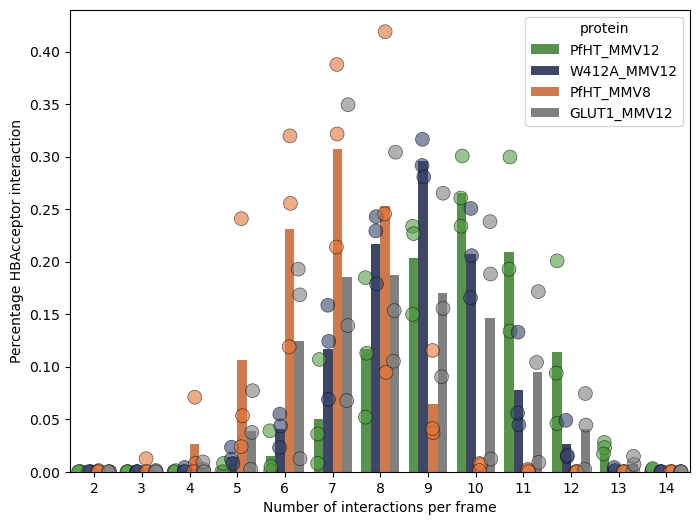

In [186]:
f,ax = plt.subplots(1,1, figsize=(8,6))
sns.barplot(data=n_intxns, 
            x='n_interactions',
            y='value',
            hue= 'protein',
            errorbar= None,
            ax= ax,
            palette= color_l
            )

sns.stripplot(data=n_intxns, 
            x='n_interactions',
            y='value',
            hue= 'protein',
            ax= ax,
            dodge=True,
            alpha= 0.6,
            edgecolor='black',
            linewidth=0.5,
            legend=False,
            size=10,
            palette= color_l
            )

ax.set_ylabel(f"Percentage {intxn_name} interaction")
ax.set_xlabel('Number of interactions per frame')
#ax.set_ylim(0,1.1)

#### Method 2 - Let sns do histogramming for you

This requires that `value_counts` is `False` (same with `percentage`). This will then only take the sum of the interactions across the dataframe.


This also means that the index that you reset and melt onto will be called `Frame`, as left from the prolif fingerprint

In [193]:
n_intxns_per_frame= pct_interactions_per_frame(intxn_name='Hydrophobic',
                                     all_fp_dfs= all_fp_dfs,
                                     value_counts=False,
                                     percentage=False)
n_intxns_per_frame = process_wide_df(
    df= n_intxns_per_frame,
    index_col_name='Frame',    # index name is also Frame, but this is actually informative, so we rename it to the same name, and melt on this value
    condition_to_remove=None,
    index_name='Frame',
    top_level_melt_name='protein',
    lower_level_melt_name='replica',
    add_21=False
)

"\nsns.stripplot(data=n_intxns, \nx='n_interactions',\ny='value',\nhue= 'protein',\nax= ax,\ndodge=True,\nalpha= 0.6,\nedgecolor='black',\nlinewidth=0.5,\nlegend=False,\nsize=5,\npalette= color_l\n)\n"

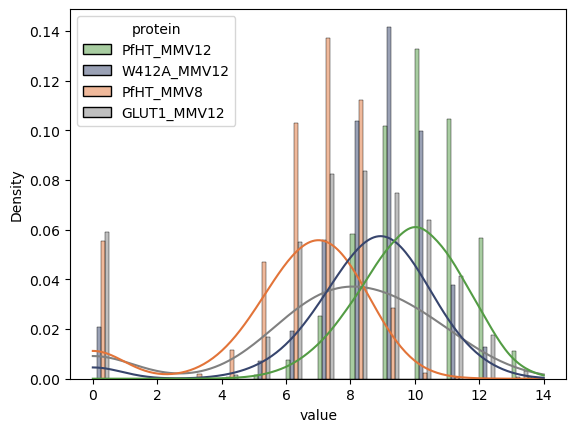

In [195]:
f, ax = plt.subplots(1,1)
sns.histplot(data=n_intxns_per_frame, 
            x='value',
            hue='protein',
            palette= color_l, 
            stat='density',
            kde_kws= {'bw_adjust':2},
            element='bars',
            binwidth=0.5,
            multiple='dodge',
            ax=ax,
            kde=True
            )
'''
sns.stripplot(data=n_intxns, 
x='n_interactions',
y='value',
hue= 'protein',
ax= ax,
dodge=True,
alpha= 0.6,
edgecolor='black',
linewidth=0.5,
legend=False,
size=5,
palette= color_l
)
'''

## TODO - still not sure how to include replicas in this graph. Need to tinker